In [17]:
import json
import itertools
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import skimage.io as io

### Load the annotations file into a COCO dataset

In [18]:
dataDir = Path('/home/samuelkim/.kaggle/data/sartorius')
annFile = Path('/home/samuelkim/.kaggle/data/sartorius/json_kaggle/annotations_all.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds[-3:])

loading annotations into memory...
Done (t=1.25s)
creating index...
index created!


### Load the first three images and display objects bitmasks and bounding boxes

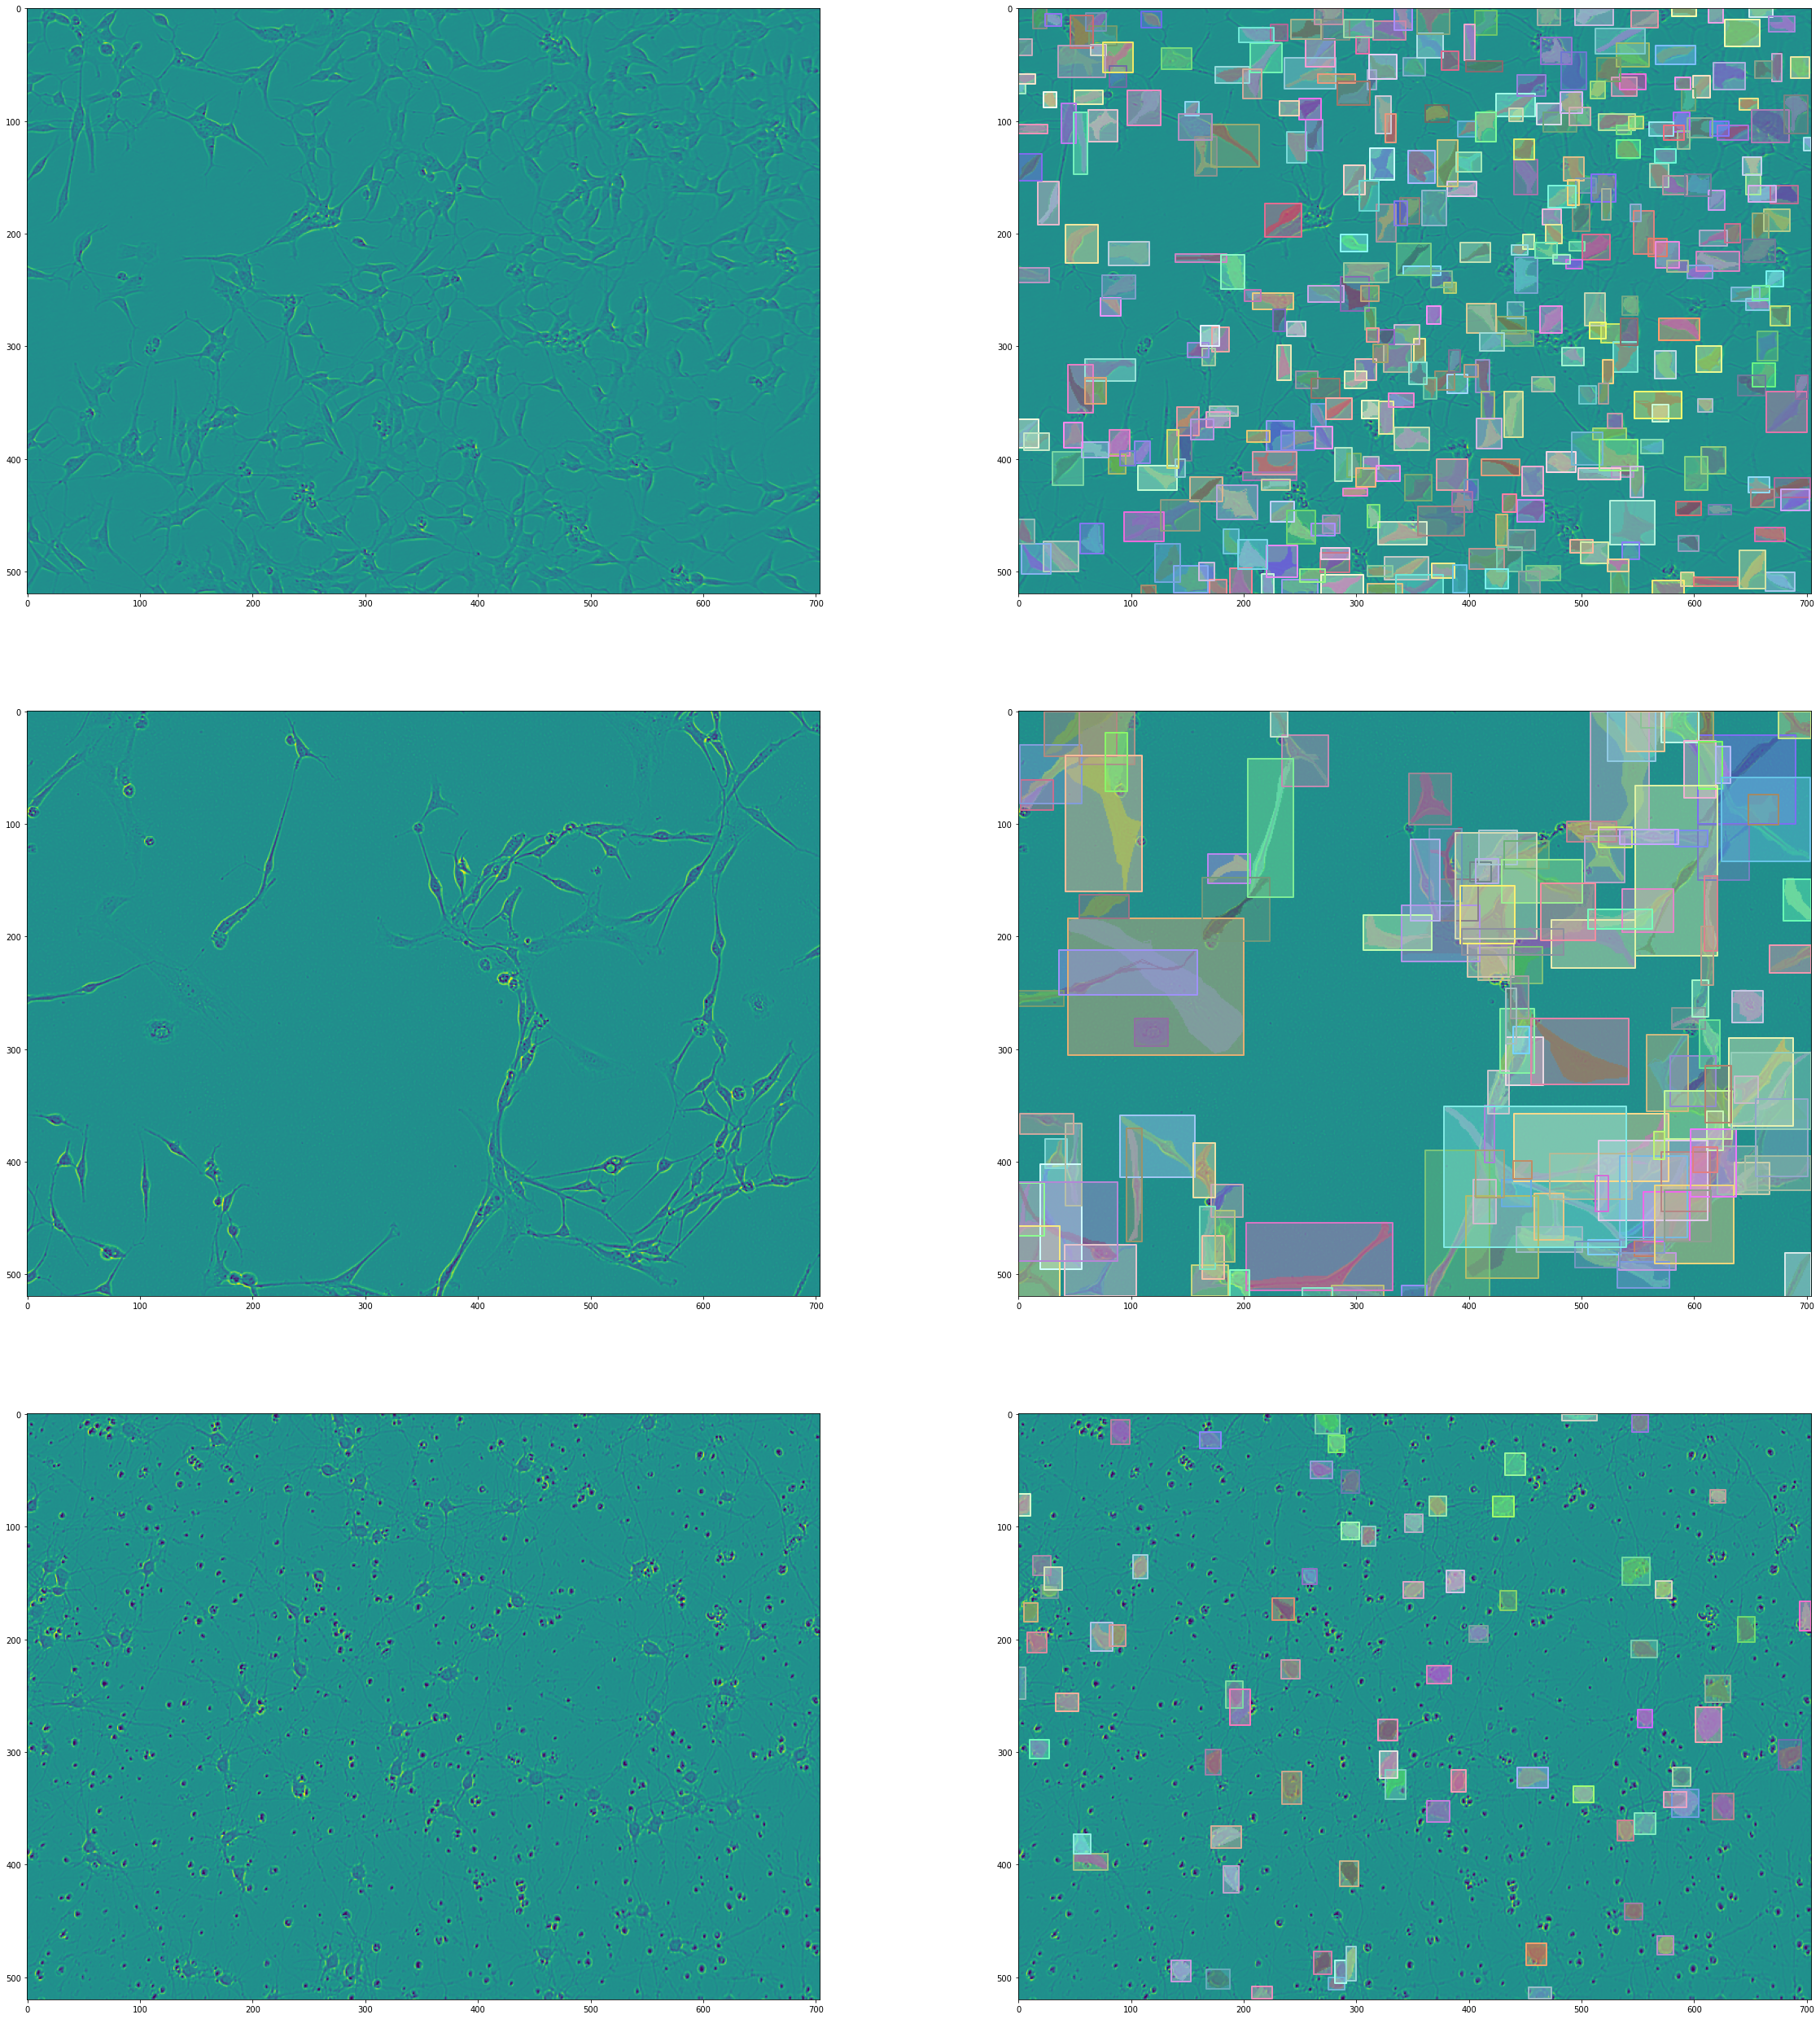

In [19]:
imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = io.imread(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)

### Generating coco format

In [21]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

# From https://newbedev.com/encode-numpy-array-using-uncompressed-rle-for-coco-dataset
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(itertools.groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    return rle

In [22]:
def coco_structure(train_df):
    # cat_ids = {name:id+1 for id, name in enumerate(train_df.cell_type.unique())} 
    cat_ids = {
        'shsy5y': 1,
        'astro': 2,
        'cort': 3
    }   
    cats =[{'name':name, 'id':id} for name,id in cat_ids.items()]
    images = [{'id':id, 'width':row.width, 'height':row.height, 'file_name':f'train/{id}.png'} for id,row in train_df.groupby('id').agg('first').iterrows()]
    annotations=[]
    for idx, row in tqdm(train_df.iterrows(), disable=True):
        mk = rle_decode(row.annotation, (row.height, row.width))
        ys, xs = np.where(mk)
        x1, x2 = min(xs), max(xs)
        y1, y2 = min(ys), max(ys)
        enc =binary_mask_to_rle(mk)
        seg = {
            'segmentation':enc, 
            'bbox': [int(x1), int(y1), int(x2-x1+1), int(y2-y1+1)],
            'area': int(np.sum(mk)),
            'image_id':row.id, 
            'category_id':cat_ids[row.cell_type], 
            'iscrowd':0, 
            'id':idx
        }
        annotations.append(seg)
    return {'categories':cats, 'images':images,'annotations':annotations}

In [23]:
base_dir = '/home/samuelkim/.kaggle/data/sartorius/json_kaggle/'
train_json = base_dir + 'annotations_train.json'
val_json = base_dir + 'annotations_val.json'

with open(train_json, 'r') as js:
    train_data = json.load(js)

with open(val_json, 'r') as js:
    val_data = json.load(js)

val_data.keys()

dict_keys(['categories', 'images', 'annotations'])

In [24]:
val_data['images'][0]

{'id': '0140b3c8f445',
 'width': 704,
 'height': 520,
 'file_name': 'train/0140b3c8f445.png'}

In [25]:
val_ids = []

for img in val_data['images']:
    val_ids.append(img['id'])

In [26]:
train_df = pd.read_csv('/home/samuelkim/.kaggle/data/sartorius/train.csv')
train_meta = train_df.groupby('id').first().reset_index()

train_meta.head()

id                                         annotation  width  \
0  0030fd0e6378  118145 6 118849 7 119553 8 120257 8 120961 9 1...    704   
1  0140b3c8f445  32499 3 33201 7 33902 9 34604 10 35306 11 3600...    704   
2  01ae5a43a2ab  241026 3 241726 9 242427 13 243130 14 243834 1...    704   
3  026b3c2c4b32  170753 5 171454 12 172158 13 172862 13 173565 ...    704   
4  029e5b3b89c7  139142 7 139845 10 140548 13 141251 15 141955 ...    704   

   height cell_type plate_time sample_date  \
0     520    shsy5y  11h30m00s  2019-06-16   
1     520     astro  09h00m00s  2020-09-13   
2     520      cort  13h30m00s  2020-11-04   
3     520      cort  19h30m00s  2020-11-04   
4     520      cort  13h30m00s  2020-10-27   

                              sample_id elapsed_timedelta  
0    shsy5y[diff]_E10-4_Vessel-714_Ph_3   0 days 11:30:00  
1    astros[cereb]_F8-3_Vessel-361_Ph_4   0 days 09:00:00  
2   cort[oka-high]_B5-1_Vessel-377_Ph_1   0 days 13:30:00  
3    cort[oka-low]_H6-2_Vessel-377_Ph_2   0 days 19:30:00  
4  cort[pre-treat]_B8-2_Vessel-377_Ph_2   0 days 13:30:00

In [27]:
len(train_meta)

606

In [28]:
val_meta = train_meta[train_meta['id'].isin(val_ids)].reset_index(drop=True)

len(val_meta)

121

In [29]:
val_meta.head()

id                                         annotation  width  \
0  0140b3c8f445  32499 3 33201 7 33902 9 34604 10 35306 11 3600...    704   
1  026b3c2c4b32  170753 5 171454 12 172158 13 172862 13 173565 ...    704   
2  029e5b3b89c7  139142 7 139845 10 140548 13 141251 15 141955 ...    704   
3  0323e81d23d9  244004 3 244705 8 245407 12 246109 15 246811 1...    704   
4  042c17cd9143  34611 1 35314 3 36016 5 36719 7 37422 8 38124 ...    704   

   height cell_type plate_time sample_date  \
0     520     astro  09h00m00s  2020-09-13   
1     520      cort  19h30m00s  2020-11-04   
2     520      cort  13h30m00s  2020-10-27   
3     520      cort  13h30m00s  2020-11-07   
4     520    shsy5y  11h30m00s  2019-06-14   

                              sample_id elapsed_timedelta  
0    astros[cereb]_F8-3_Vessel-361_Ph_4   0 days 09:00:00  
1    cort[oka-low]_H6-2_Vessel-377_Ph_2   0 days 19:30:00  
2  cort[pre-treat]_B8-2_Vessel-377_Ph_2   0 days 13:30:00  
3   cort[density]_B11-4_Vessel-376_Ph_4   0 days 13:30:00  
4     shsy5y[diff]_E8-4_Vessel-714_Ph_1   0 days 11:30:00

In [30]:
from sklearn.model_selection import StratifiedKFold

n_splits = 2
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2022)
for fold, (_, val_idx) in enumerate(skf.split(X=val_meta, y=val_meta['cell_type']), 1):
    val_meta.loc[val_idx, 'fold'] = fold
    
val_meta['fold'] = val_meta['fold'].astype(np.uint8)
val_meta.groupby('fold').size()

fold
1    61
2    60
dtype: int64

In [31]:
json_dir = '/home/samuelkim/.kaggle/data/sartorius/json_kaggle'

for fold in range(1, 3):

    base_dir = '/home/samuelkim/.kaggle/data/sartorius/json_kaggle/'
    train_json = base_dir + 'annotations_train.json'

    with open(train_json, 'r') as js:
        train_data = json.load(js)

    print(f'saving {fold} json ...')
    
    train_ids = val_meta[val_meta["fold"] != fold].id
    val_ids = val_meta[val_meta["fold"] == fold].id

    df_train = train_df[train_df.id.isin(train_ids)]
    df_valid = train_df[train_df.id.isin(val_ids)]

    train_json = coco_structure(df_train)
    valid_json = coco_structure(df_valid)

    train_data['images'] = train_data['images'] + train_json['images']
    train_data['annotations'] = train_data['annotations'] + train_json['annotations']

    with open(f'{json_dir}/annotations_train_090_{fold}.json', 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=True, indent=4)

    with open(f'{json_dir}/annotations_val_010_{fold}.json', 'w', encoding='utf-8') as f:
        json.dump(valid_json, f, ensure_ascii=True, indent=4)

saving 1 json ...
saving 2 json ...


In [34]:
base_dir = '/home/samuelkim/.kaggle/data/sartorius/json_kaggle/'
train_json = base_dir + 'annotations_train_090_1.json'
val_json = base_dir + 'annotations_val_010_1.json'

with open(train_json, 'r') as js:
    train_new = json.load(js)

with open(val_json, 'r') as js:
    val_new = json.load(js)

In [35]:
print(len(train_new['images']), len(val_new['images']))

545 61
